In [ ]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


btc_data = yf.download('BTC-USD', start='2015-01-01', end='2024-12-31')


print(btc_data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2015-01-01  314.248993  320.434998  314.002991  320.434998   8036550
2015-01-02  315.032013  315.838989  313.565002  314.079010   7860650
2015-01-03  281.082001  315.149994  281.082001  314.846008  33054400
2015-01-04  264.195007  287.230011  257.612000  281.145996  55629100
2015-01-05  274.473999  278.341003  265.084015  265.084015  43962800


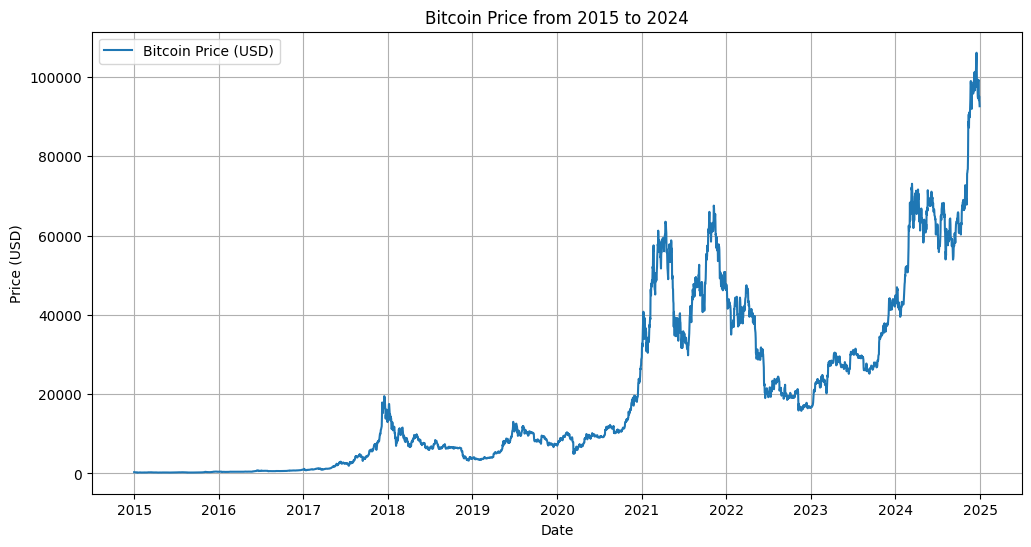


Daily Returns:
 Date
2015-01-02    0.002492
2015-01-03   -0.107767
2015-01-04   -0.060079
2015-01-05    0.038907
2015-01-06    0.042682
Name: Returns, dtype: float64


In [ ]:
# closing price of Bitcoin
plt.figure(figsize=(12, 6))
plt.plot(btc_data['Close'], label='Bitcoin Price (USD)')
plt.title('Bitcoin Price from 2015 to 2024')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Daily Returns
btc_data['Returns'] = btc_data['Close'].pct_change()
print("\nDaily Returns:\n", btc_data['Returns'].dropna().head())

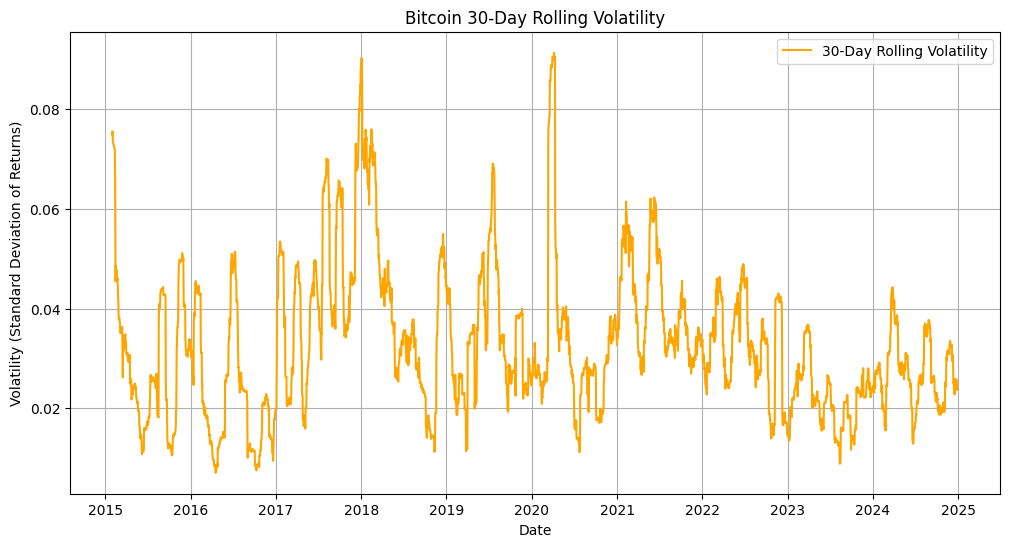

In [ ]:
# 30-day Rolling Volatility
btc_data['RollingVolatility'] = btc_data['Returns'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(btc_data['RollingVolatility'], label='30-Day Rolling Volatility', color='orange')
plt.title('Bitcoin 30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation of Returns)')
plt.legend()
plt.grid(True)
plt.show()


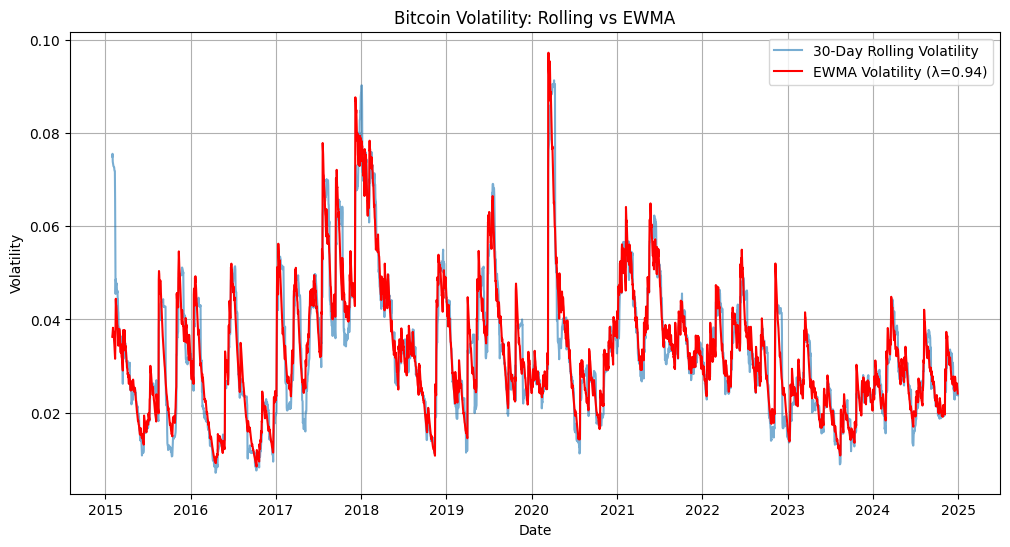

In [ ]:
# lambda (smoothing factor)
lambda_ = 0.94

# EWMA volatility
btc_data['EWMA_Volatility'] = np.nan
initial_var = btc_data['Returns'].var()
btc_data.iloc[30, btc_data.columns.get_loc('EWMA_Volatility')] = np.sqrt(initial_var)

# Apply EWMA recursively from day 31 onward
for t in range(31, len(btc_data)):
    prev_vol = btc_data.iloc[t-1]['EWMA_Volatility']
    ret = btc_data.iloc[t]['Returns']
    ewma_var = lambda_ * prev_vol**2 + (1 - lambda_) * ret**2
    btc_data.iloc[t, btc_data.columns.get_loc('EWMA_Volatility')] = np.sqrt(ewma_var)

# EWMA vs Rolling Volatility
plt.figure(figsize=(12, 6))
plt.plot(btc_data['RollingVolatility'], label='30-Day Rolling Volatility', alpha=0.6)
plt.plot(btc_data['EWMA_Volatility'], label='EWMA Volatility (λ=0.94)', color='red')
plt.title('Bitcoin Volatility: Rolling vs EWMA')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 25.9 MB/s eta 0:00:00


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9556.74
Distribution:                  Normal   AIC:                           19121.5
Method:            Maximum Likelihood   BIC:                           19146.3
                                        No. Observations:                 3651
Date:                Wed, Apr 30 2025   Df Residuals:                     3650
Time:                        03:54:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2172  4.909e-02      4.425  9.653e-06 [  0.121,  0.31

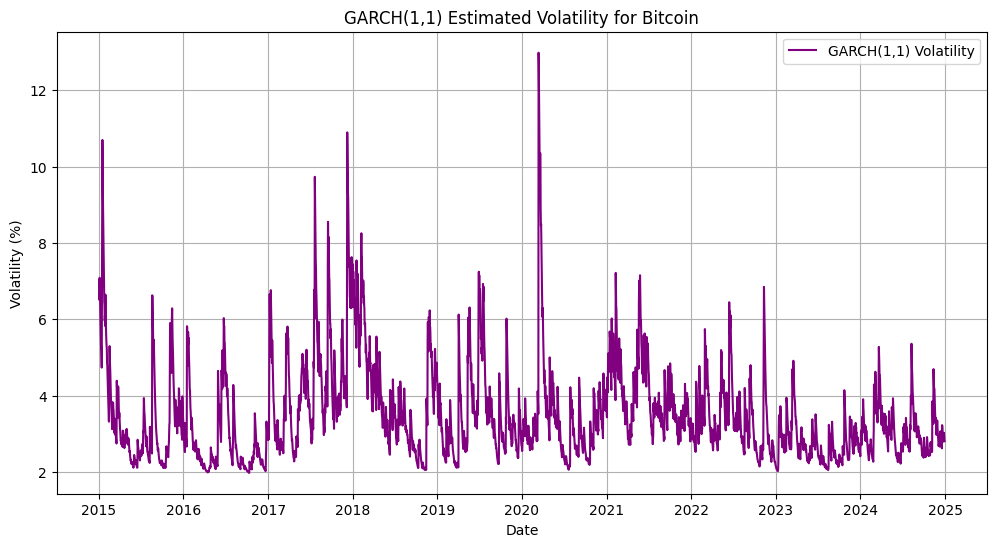

In [ ]:

from arch import arch_model


returns = btc_data['Returns'].dropna() * 100

#GARCH(1,1) model
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

print(garch_fit.summary())

# conditional volatility estimated by GARCH
plt.figure(figsize=(12, 6))
plt.plot(garch_fit.conditional_volatility, color='purple', label='GARCH(1,1) Volatility')
plt.title('GARCH(1,1) Estimated Volatility for Bitcoin')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()


While Katsiampa (2017) found AR-CGARCH to be the optimal model, our Python implementation uses GARCH(1,1) due to package limitations. GARCH still captures persistent and clustered volatility, which aligns with the paper’s findings

# Hedging Strategies

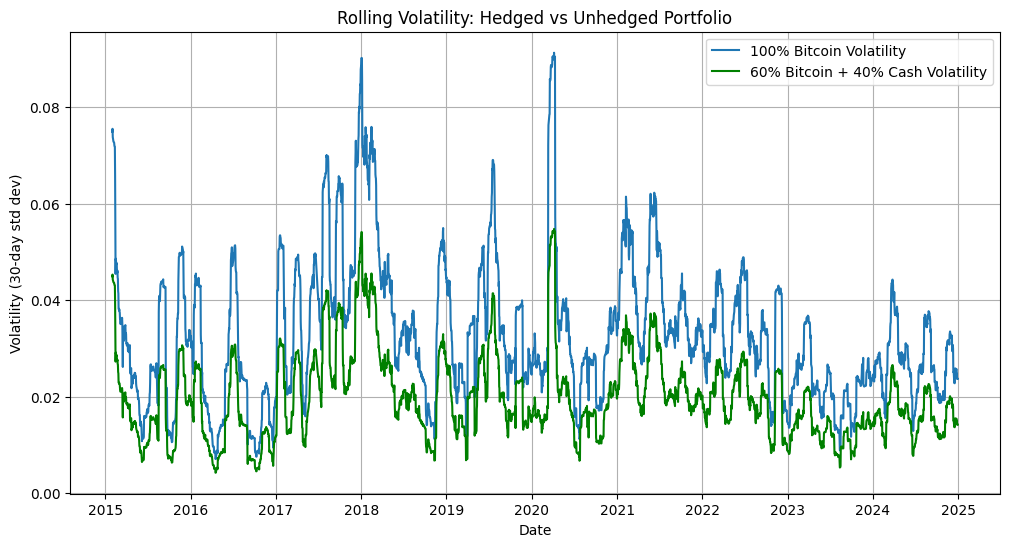

In [ ]:

btc_returns = btc_data['Returns'].dropna()

# Hedged portfolio return: 60% BTC + 40% risk-free (0% return)
hedged_returns = 0.6 * btc_returns

portfolio_df = pd.DataFrame({
    'Bitcoin': btc_returns,
    'Hedged_60_40': hedged_returns
})

# Rolling volatility (30-day) of both
rolling_vol = portfolio_df.rolling(window=30).std()
plt.figure(figsize=(12, 6))
plt.plot(rolling_vol['Bitcoin'], label='100% Bitcoin Volatility')
plt.plot(rolling_vol['Hedged_60_40'], label='60% Bitcoin + 40% Cash Volatility', color='green')
plt.title('Rolling Volatility: Hedged vs Unhedged Portfolio')
plt.xlabel('Date')
plt.ylabel('Volatility (30-day std dev)')
plt.legend()
plt.grid(True)
plt.show()



In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

data = yf.download(
    ['BTC-USD', '^GSPC', 'GC=F'],
    start='2015-01-01',
    end='2024-12-31'
)



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

data = yf.download(
    ['BTC-USD', '^GSPC', 'GC=F'],
    start='2015-01-01',
    end='2024-12-31'
)['Close']

data.columns = ['Bitcoin', 'S&P 500', 'Gold']

data.dropna(inplace=True)
log_returns = np.log(data / data.shift(1)).dropna()

print(log_returns.head())


[*********************100%***********************]  3 of 3 completed

             Bitcoin   S&P 500      Gold
Date                                    
2015-01-05 -0.137818  0.014980 -0.018447
2015-01-06  0.041796  0.012711 -0.008933
2015-01-07  0.028073 -0.007161  0.011563
2015-01-08 -0.038046 -0.001819  0.017730
2015-01-09  0.024607  0.006270 -0.008439


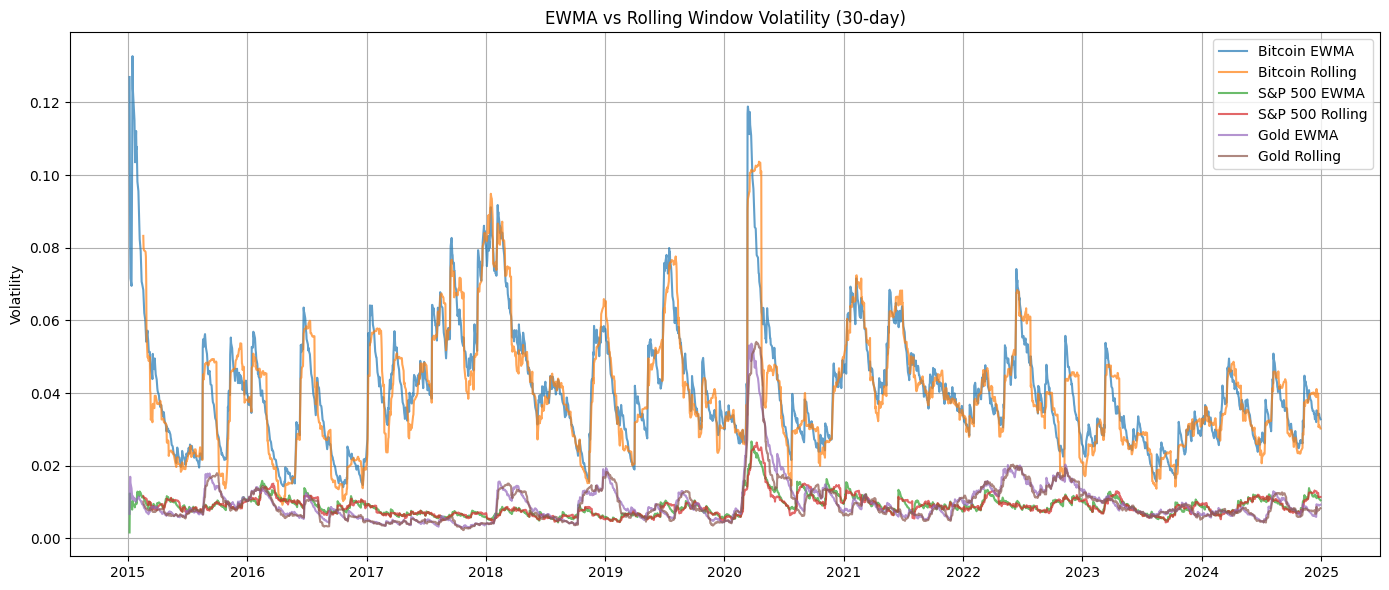

In [11]:

lambda_ = 0.94
window = 30

# EWMA volatility
ewma_vol = log_returns.ewm(span=(2/(1-lambda_)-1)).std()

# Rolling window volatility
rolling_vol = log_returns.rolling(window=window).std()

plt.figure(figsize=(14, 6))
plt.plot(ewma_vol['Bitcoin'], label='Bitcoin EWMA', alpha=0.7)
plt.plot(rolling_vol['Bitcoin'], label='Bitcoin Rolling', alpha=0.7)
plt.plot(ewma_vol['S&P 500'], label='S&P 500 EWMA', alpha=0.7)
plt.plot(rolling_vol['S&P 500'], label='S&P 500 Rolling', alpha=0.7)
plt.plot(ewma_vol['Gold'], label='Gold EWMA', alpha=0.7)
plt.plot(rolling_vol['Gold'], label='Gold Rolling', alpha=0.7)

plt.title('EWMA vs Rolling Window Volatility (30-day)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:

def summarize_volatility(vol_df, label):
    return pd.DataFrame({
        'Asset': vol_df.columns,
        'Method': label,
        'Mean Volatility': vol_df.mean().values,
        'Max Volatility': vol_df.max().values,
        'Std of Volatility': vol_df.std().values
    })

summary_ewma = summarize_volatility(ewma_vol, 'EWMA')
summary_rolling = summarize_volatility(rolling_vol, 'Rolling')

summary_table = pd.concat([summary_ewma, summary_rolling])
summary_table.reset_index(drop=True, inplace=True)

In [9]:
pip install ace_tools

In [13]:

def summarize_volatility(vol_df, label):
    return pd.DataFrame({
        'Asset': vol_df.columns,
        'Method': label,
        'Mean Volatility': vol_df.mean().values,
        'Max Volatility': vol_df.max().values,
        'Std of Volatility': vol_df.std().values
    })


summary_ewma = summarize_volatility(ewma_vol, 'EWMA')
summary_rolling = summarize_volatility(rolling_vol, 'Rolling')


summary_table = pd.concat([summary_ewma, summary_rolling]).reset_index(drop=True)


print(summary_table)


     Asset   Method  Mean Volatility  Max Volatility  Std of Volatility
0  Bitcoin     EWMA         0.040880        0.132750           0.016461
1  S&P 500     EWMA         0.008864        0.026657           0.002702
2     Gold     EWMA         0.009655        0.053588           0.005946
3  Bitcoin  Rolling         0.039774        0.103702           0.016519
4  S&P 500  Rolling         0.008822        0.026362           0.002817
5     Gold  Rolling         0.009511        0.054091           0.006172


In [14]:

crypto_data = yf.download(
    ['BTC-USD', 'ETH-USD', 'LTC-USD'],
    start='2015-01-01',
    end='2024-12-31'
)['Close']


crypto_data.columns = ['Bitcoin', 'Ethereum', 'Litecoin']


crypto_data.dropna(inplace=True)

#  log returns
crypto_returns = np.log(crypto_data / crypto_data.shift(1)).dropna()

# volatility: EWMA and Rolling
crypto_ewma = crypto_returns.ewm(span=(2/(1-0.94)-1)).std()
crypto_rolling = crypto_returns.rolling(window=30).std()


[*********************100%***********************]  3 of 3 completed


In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

crypto_data = yf.download(
    ['BTC-USD', 'ETH-USD', 'LTC-USD'],
    start='2015-01-01',
    end='2024-12-31'
)['Close']

crypto_data.columns = ['Bitcoin', 'Ethereum', 'Litecoin']

#log returns
crypto_data.dropna(inplace=True)
crypto_returns = np.log(crypto_data / crypto_data.shift(1)).dropna()

# EWMA and Rolling volatilities
ewma_vol = crypto_returns.ewm(span=(2/(1-0.94)-1)).std()
rolling_vol = crypto_returns.rolling(window=30).std()


[*********************100%***********************]  3 of 3 completed


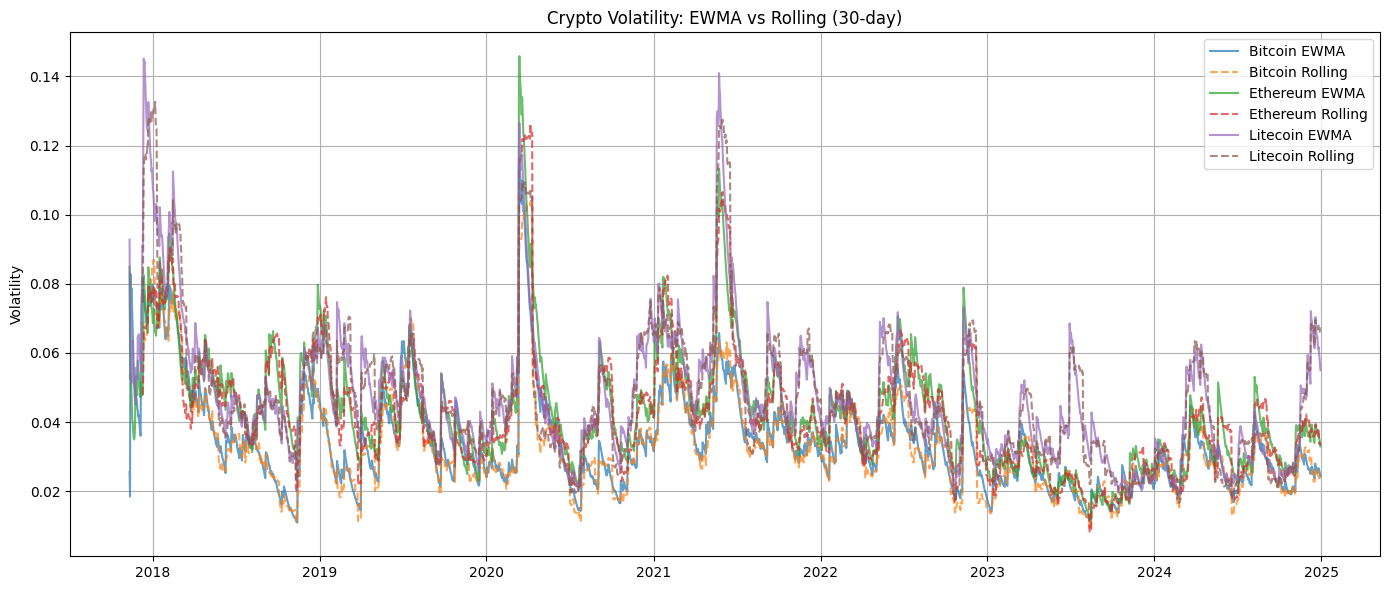

In [16]:
plt.figure(figsize=(14, 6))
for coin in crypto_returns.columns:
    plt.plot(ewma_vol[coin], label=f"{coin} EWMA", alpha=0.7)
    plt.plot(rolling_vol[coin], label=f"{coin} Rolling", linestyle='--', alpha=0.7)

plt.title("Crypto Volatility: EWMA vs Rolling (30-day)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Combined summaries
def summarize_vol(df, method):
    return pd.DataFrame({
        'Crypto': df.columns,
        'Method': method,
        'Mean Volatility': df.mean().values,
        'Max Volatility': df.max().values,
        'Std of Volatility': df.std().values
    })

summary_table = pd.concat([
    summarize_vol(ewma_vol, 'EWMA'),
    summarize_vol(rolling_vol, 'Rolling')
]).reset_index(drop=True)

print(summary_table)


     Crypto   Method  Mean Volatility  Max Volatility  Std of Volatility
0   Bitcoin     EWMA         0.033955        0.116350           0.014385
1  Ethereum     EWMA         0.043011        0.145881           0.017073
2  Litecoin     EWMA         0.047130        0.145158           0.019229
3   Bitcoin  Rolling         0.033416        0.103649           0.014815
4  Ethereum  Rolling         0.042563        0.126367           0.017866
5  Litecoin  Rolling         0.046530        0.132644           0.020116


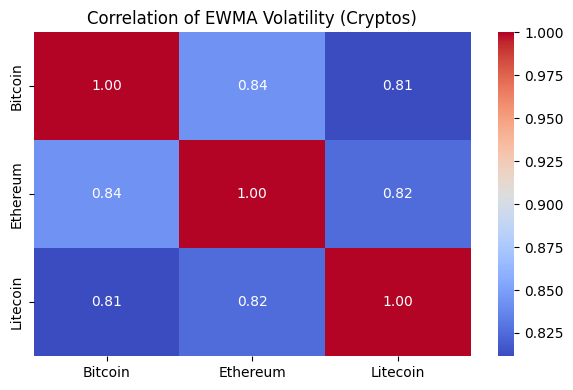

In [20]:
plt.figure(figsize=(6, 4))
sns.heatmap(ewma_vol.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of EWMA Volatility (Cryptos)")
plt.tight_layout()
plt.show()


<ipython-input-21-25383107b848>:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance, 'single')


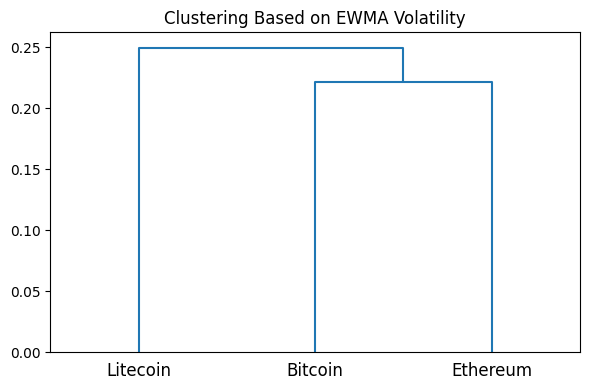

In [21]:
# Use correlation distance
distance = 1 - ewma_vol.corr()
linked = linkage(distance, 'single')

# Dendrogram
plt.figure(figsize=(6, 4))
dendrogram(linked, labels=ewma_vol.columns.tolist())
plt.title("Clustering Based on EWMA Volatility")
plt.tight_layout()
plt.show()


In [1]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram


In [6]:
# If ewma_vol already exists and contains Bitcoin, Ethereum, Litecoin
correlation_matrix = ewma_vol.corr()

#distance matrix: 1 - correlation
distance_matrix = 1 - correlation_matrix


In [7]:
# Hierarchical clustering using 'single' linkage
linked = linkage(distance_matrix, method='single')


<ipython-input-7-7e9cbaeec974>:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='single')


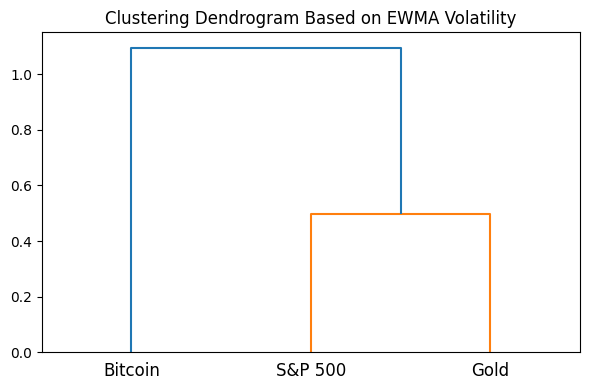

In [8]:
plt.figure(figsize=(6, 4))
dendrogram(linked, labels=ewma_vol.columns.tolist())
plt.title("Clustering Dendrogram Based on EWMA Volatility")
plt.tight_layout()
plt.savefig("ewma_volatility_dendrogram.png")
plt.show()


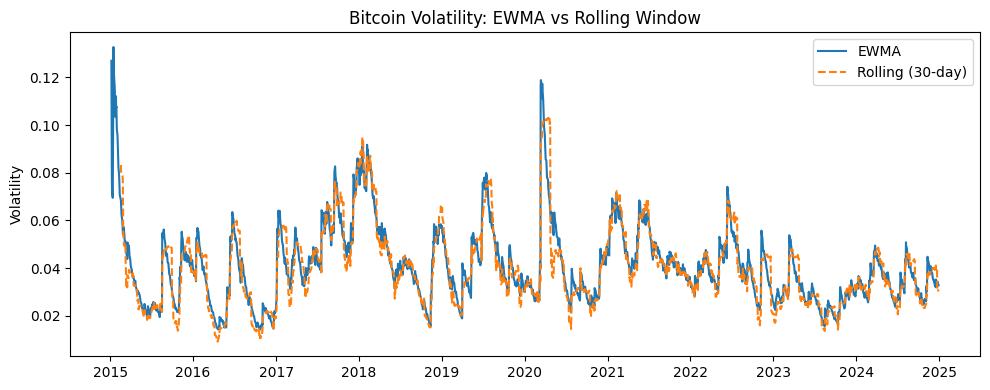

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(ewma_vol['Bitcoin'], label='EWMA')
plt.plot(rolling_vol['Bitcoin'], label='Rolling (30-day)', linestyle='--')
plt.title("Bitcoin Volatility: EWMA vs Rolling Window")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.savefig("bitcoin_ewma_vs_rolling.png")
plt.show()


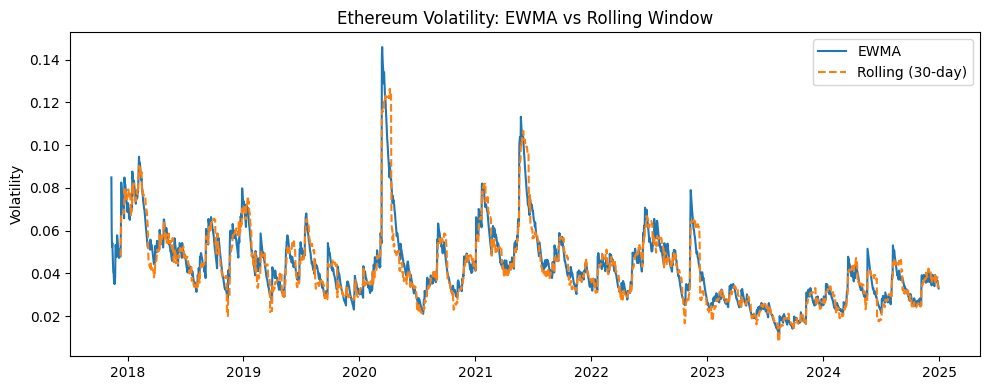

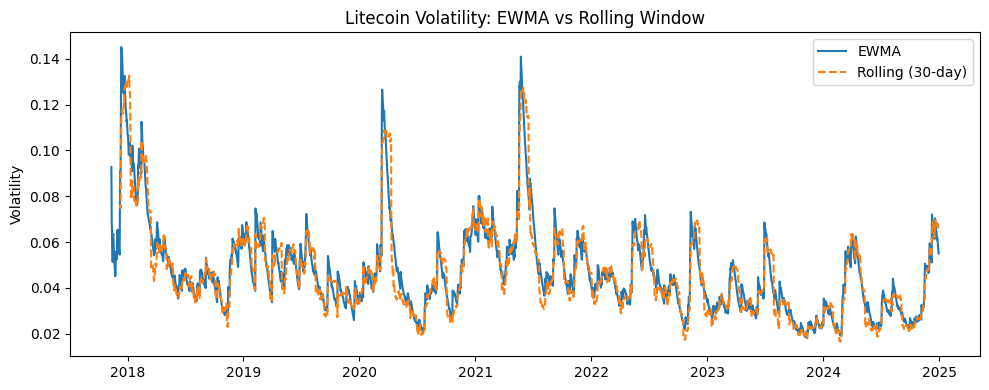

In [17]:
for coin in ['Ethereum', 'Litecoin']:
    plt.figure(figsize=(10, 4))
    plt.plot(ewma_vol[coin], label='EWMA')
    plt.plot(rolling_vol[coin], label='Rolling (30-day)', linestyle='--')
    plt.title(f"{coin} Volatility: EWMA vs Rolling Window")
    plt.ylabel("Volatility")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{coin.lower()}_ewma_vs_rolling.png")
    plt.show()


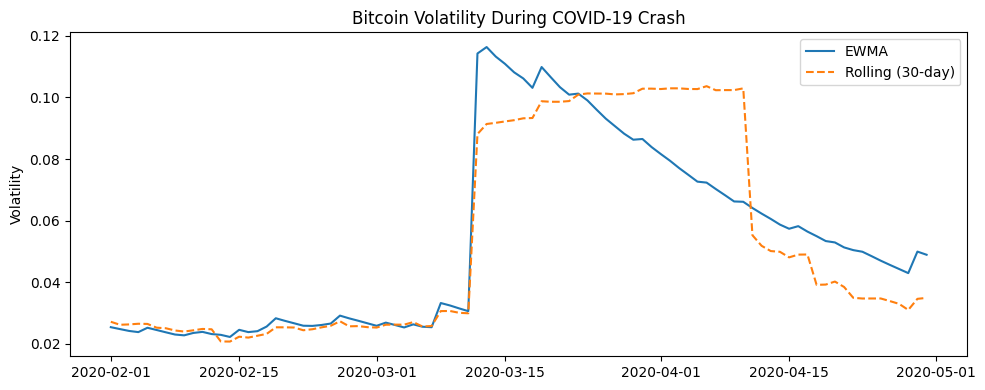

In [18]:
# Focus on early 2020
start, end = '2020-02-01', '2020-04-30'
plt.figure(figsize=(10, 4))
plt.plot(ewma_vol['Bitcoin'][start:end], label='EWMA')
plt.plot(rolling_vol['Bitcoin'][start:end], label='Rolling (30-day)', linestyle='--')
plt.title("Bitcoin Volatility During COVID-19 Crash")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.savefig("bitcoin_covid_volatility.png")
plt.show()
